# Analysis of TSP Approximation Algorithms
## Introduction to TSP
The problem is often described as a salesman who would like to visit each city no more than once and return home. The journey to each city has a certain expense; the salesman would like to find the most optimal solution. This can be represented with edge weights between the vertices. So we want to find a route where the sum of the edge weights is the lowest possible value. Given a large set of cities (nodes) this has proven to be an intractable problem- it's NP-hard. 

Before getting into it, let's consider two other common paths that may traverse a graph. The first is an Eulerian circuit which touches every node in the graph and returns to the origin. The second is a Hamiltonian cycle which similar to the Eulerian cycle in that it must touch every node and return to the origin. However the Hamiltonian cycle mandates that each node is only visited once. This is quite similar to the Traveling Salesperson Problem, a reduction can be shown to prove that TSP is NP-hard without too much massaging. Think of the Traveling Salesman Problem as finding the Hamiltonian cycle with the minimum possible weight.

It's important to note that the algorithms in question, and indeed the ones implemented below, are only approximations. Approximations appear to be the only way to solve inputs that are millions of cities large. They find solutions with approximation ratios that may be considered "good enough". Good enough of course depends on the standard one chooses to hold, but algorithms of note seem to yield a solution which is 2-3% close to optimal.[1] One of the approximations will fail terribly, this is the nearest neighbor. Christofides actually does quite well, yielding the best approximation ratio of all known algorithms in the general case. 

## Why I chose this algorithm

## Graph theory primer
This is a graph problem, being as such there are a few properties we can exploit, and some that will hinder us. We already talked about the Hamiltonian Cycle and its relationship with the Traveling Salesperson Problem, but we didn't consider the graph itself. There are two types of graphs of note. One is a complete graph and the other is not. A complete graph means that all edges in the graph can reach every other edge. Any two nodes in a graph that are not connected makes a graph incomplete, but it may still be connected. A connected graph means that, by some path, we can reach every node. This is usually verified by running DFS on the graph, an operation that has a smaller time complexity than the algorithm for finding a TSP solution. In fact, the input graph is verified at the beginning to confirm it's connectivity.

Let's consider the graph's nodes (vertices). For this problem we'll need to keep an associated attribute with the node to determine if it has already been visited. Remember, we're not allowed to visit the same city twice. We'll also want to note the origin, or the location that we've started at because the result should be a cycle. This means that our salesperson returns to the place from which they began. Nodes are pretty straight forward, as long as they're connected by edges we should be alright.

Now for the edges, which have slightly more interesting properties. This is an undirected graph, which generally makes traversal more simple. This means that an edge can be taken in either direction. Edges also have a second property, which is their weight. The weight of an edge is an attribute that states how costly it will be for our salesperson to travel from the current node along that edge to the next node. The graphs used here are not plotted on a Cartesian coordinate system. This means that the distance between a pair of nodes has nothing to do with the weight of the edge. As an aside, the graphs plotted below have nodes placed in a screw formation to make them readable. Graphviz, another plotting tool, makes graphs where the nodes do not overlap and the edges can be traced. Back to these edges; another constraint on the weights are that they cannot be negative. This is useful for the functions, and makes sense in reality. A salesperson cannot go a negative distance, as it really has no meaning. Finally, let's acknowledge the variation in weights. I've set the upper bound to be about twice as much as the number of nodes. However, there may still be two edges with the same value incident to a node. Which edges will be taken depends on the alogrithm in question, but it should make no difference in analysis.

To elaborate slightly more on the cycles that are discovered, first remember that we're looking for a best approximation. While it may make sense to try an algorithm more than once from various origins, it seems fitting that we'll just accept the bad answer that we're provided on the first completion. This saves us from the rabbit hole of searching for an optimal solution using an algorithm that we know may not provide one. So once a valid Hamiltonian cycle is found, we consider that the result of the algorithm. With a completed graph this should always execute on the first try. However, if the graph is not complete we may exhaust other origins in an attempt to find the cycle. Importantly, an algorithm may not find a path for our salesperson even though one exists if the input graph is not connected.

Lastly, it must be explicitly addressed that we're looking for an approximation algorithm. These are not guaranteed to yield an optimal solution, in fact they likely won't. There is need for a metric to compare these algorithms and the optimal solution is the clear choice. For large inputs a known optimal solution can be pitted against the algorithms developed here. The way to measure how well one algorithm did in comparison to the optimal path is to take the ratio of the two. This is known as the approximation ratio. 

## Nearest neighbor
This algorithm is a great example of what not to do. For one, it very easily will not find a solution even when one is evident. Nearest neighbor is a greedy algorithm which means it will take whatever choice looks best from its current position. When it arrives at a node it evaluates each of the neighboring nodes and determines which have yet to be accessed. Then it takes the lowest weight of those possibilities. It's horribly simple, but will always find a solution on a completed graph. The approximation ratio from various sources state that it gets to within 15-25% of the optimal solution.

You may notice that this is a silly procedure as it could funnel its way into a trap from which it cannot return. This tends to happen most with triangle shapes where the point furthest from the origin has the heaviest edge of the three that comprise the triangle. This is because it will navigate the base of the triangle, then greedily turn away from the origin and towards the point of the triangle. From here it cannot return as it's already touched the two base nodes. Surely there are other mistakes that this algorithm can make, but this one happens to be easiest to imagine.

Without a map, this may be the way someone would travel in reality. If you think about it, we're just taking the path of least resistance. If what's immediately in front of us proves to be a challenge (high weight), we'll look for all other routes before taking it. Clearly this is suboptimal as there are many cases in life where the challenging path up front results in a better overall result. Another issue with this algorithm is we may end up taking simple paths all the way till the end, but be forced to take an expensive path to the origin. Obviously this happens because we've removed all other nodes from the set of optional moves, but without a mechanism that provides foresight it's an unavoidable expense.

Here's some annotated [mathy stuff](https://www.youtube.com/watch?v=zM5MW5NKZJg)
```
1) The distance between any two nodes is greater than or equal to zero 
     d(x,y) >= 0
2) The graph is undirected 
     d(x,y) = d(y,x) 
3) The triangle inequality exists: If a single edge reachs a point that two or more edges can reach together, the single edge is shorter than the sum of the other edges. 
     d(x,y) + d(y,z) >= d(x,z)
```

### Psuedocode
Just to be clear, the structure of the psuedocode came from Wikipedia and has been elaborated on. In general, it's standard to consider node `u` as the node we're currently at and node `v` as the node to which we may travel. This is evident based on parameters in the `networkx` python3 library used below. Also, the original psuedocode must have been written for a complete graph. The modifications made will rotate the origin through all possible nodes until a Hamiltonian cycle is found. Again, we have no way of guaranteeing a better path, so we halt on the first encountered.
```
Psuedocode
 0) sum = the total cost of traveling the paths.
 1) Initialize all vertices as unvisited and add them the list possible origins.
 2) Select a vertex from the list of possible origins, set it as the current vertex u. Mark u as visited.
 3) Find out the shortest edge e connecting the current vertex u and an unvisited vertex v.
 4) Set v as the current vertex u. Mark v as visited. Add e to sum.
 5) If u can access another vertex v that is not the origin go to step 3.
 6) Else If u can access the origin via e add e to sum and return sum
 6) Else remove the origin from the list of possible origins.  
 7)   If possible origins is empty return false, no path found.
 8)   Else go to step 2.
```
### Complexity
Of course, when analyzing an algorithm we only care about worst case complexity (big O). Here, the worst case possibility is we find our path when the last possible origin is used from the list of possible origins. This means that we have looked at each node once for every possible origin. Since all nodes are candidates for an origin, we have a `O(n^2)` algorithm. Let's put this into perspective to see how bad it is. Depth first search, an algorithm which also traverses all of the nodes in a graph, has a runtime of `O(|V|+|E|)`. You could say that it's a linear algorithm with space complexity greater than constant because it keeps track of the route taken. Well considering it's not tasked with finding a Hamiltonian circuit, nearest neighbor doesn't actually seem that bad! It's polynomial after all, and it's space complexity is just a list of all the nodes in the graph, `O(n)`. A very tolerable running time indeed. But we must not forget its numerous pitfalls. For one, it may not find a solution even though it exists. 

It's important to note that I did not implement reptitive nearest neighbor. Reptitive nearest neighbor would run the algorithm above on all inputs and store every possible route until the origin list has been exhausted. From there it would compare the different solutions and find the shortest of the paths in that data structure. In my opinion, this blows up the space complexity and would not be practical. In theory, this would have been easy to accomplish by storing the path with all of the path data in a lookup table. Now our space complexity would be `O(n^2)` since there may be a copy of all paths for each possible origin. The runtime complexity would still be `O(n^2)`. Even though it's often considered that storage is cheap, for a large graph the first Hamiltonian cycle may also prove to be a challenge. Since the results are already expected to be suboptimal, with a particular input repetitive nearest neighbor would not be necessary. Briefly, there are some interesting guarantees when iterating through every possible origin. For instance, it will always produce a tour better than at least `n/2-1`. other possible tours. Sometimes it finds a tour better than `n-2` other tours when `n >= 4`. (TODO CITE)



In [ ]:
# This cell must be run before the other cells.
import networkx as nx
import random as rng
from networkx.drawing.nx_pydot import write_dot
import matplotlib.pyplot as plt


class StopExecution(Exception):
    def _render_traceback_(self):
        pass

Number of nodes in small graph: 7


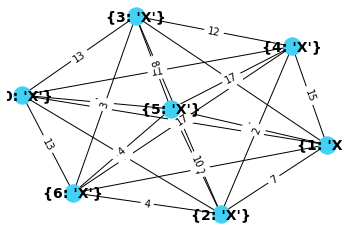

In [67]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
sm_num_of_nodes = rng.randrange(5,13)
max_edge_weight = 20
prob_of_edge_creation = 1.0

print("Number of nodes in small graph: {}".format(sm_num_of_nodes))
sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)

# only works on connected graphs.
while not nx.is_connected(sm_graph):
    sm_graph = nx.fast_gnp_random_graph(sm_num_of_nodes, prob_of_edge_creation, None, False)
    
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# for each node in the small graph, initialize it to unvisited
fresh_node_labels = [{'visited': 'X', 'origin': False}] # if `fresh_node_labels` is not a dictionary then it's applied to all nodes
nx.set_node_attributes(sm_graph, fresh_node_labels, 'node-label')

# for each node in the small graph, assign a random weight
for (u, v) in sm_graph.edges():
    sm_graph.edges[u,v]['weight'] = rng.randint(1, max_edge_weight)
    
# add edges to the small graph that is printable
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(sm_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(sm_graph, pos, edge_labels=edge_labels)

# need to remove the origin attribute being passed to `draw` to keep it clean
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}

# Draw the graph below
nx.draw(sm_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')

Two things about these chunks of code above and below. The one below is dependent on the one above, so the one above must be run first. Also, if the graph is not complete (i.e. `prob_of_edge_creation != 1.0`) then you may generate graphs which obviously don't have a Hamiltonian cycle. 

Best route nearest neighbor could find: 40


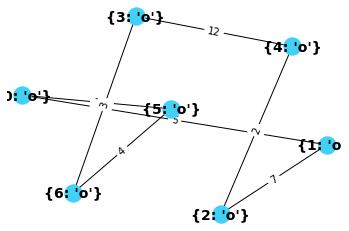

In [68]:
###############################
#     SMALL VISUAL GRAPH      #
###############################
verbose = True
output_graph = nx.create_empty_copy(sm_graph,with_data=False)

# At the beginning, all nodes are unvisited and marked with 'X'
# origin is the current_node to start
origin = rng.randrange(0, sm_num_of_nodes)
current_node = origin

# A list of attempted origins in case the origin doesn't work out.
attempted_origins = list(range(sm_num_of_nodes))

next_node = None
total_path_weight = 0
is_ham_circuit = False

# set origin to true by accessing that particular node and updating it's attribute by sending in a new dict
nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

while True:
    
    # flag to show if further travel is possible
    neighbor_exists = False
    
    # reset the highest possible weight
    lowest_weight_edge = max_edge_weight + 1

    # all nodes that share an edge incident to current_node
    neighbors = [n for n in sm_graph.neighbors(current_node)]
    
    for node in neighbors:
        
        # has the neighbor node been visited
        not_visited = sm_graph.nodes[node]['node-label'][0]['visited'] != 'o'
            
        # weight of the edge to the neighbor node
        edge_weight_to_neighbor = sm_graph.get_edge_data(current_node, node)['weight']
        
        # is neighbor node the origin
        is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
        
        # if the node hasn't been visited, the edge between this and that is current minimum, it ain't the origin
        if not_visited and edge_weight_to_neighbor < lowest_weight_edge and not is_origin:        
            
            # this is now the edge lowest weight edge leaving `u`
            lowest_weight_edge = edge_weight_to_neighbor
            next_node = node
            
            # need to know if we should try and return to origin
            neighbor_exists = True 
            
    # attempt to get back to the origin, need to iterate once more. we couldn't have taken this edge before
    if not neighbor_exists:
        for node in neighbors:
            is_origin = sm_graph.nodes[node]['node-label'][0]['origin']
            if is_origin:
                # simply add that edge weight and return
                next_edge_weight = sm_graph.get_edge_data(current_node, node)['weight']
                output_graph.add_edge(current_node, node, weight=next_edge_weight)
                total_path_weight += next_edge_weight            
                is_ham_circuit = True
                    
        if is_ham_circuit:
            break
        else:
            
            # try different origins till exhaustion
            attempted_origins.remove(origin)

            # update the origin
            if not attempted_origins:
                print("Unable to find a circuit for our salesperson.")
                raise StopExecution
            
            # get a new origin
            origin = attempted_origins[0] 
            current_node = origin

            # refresh the 'visited' attribute of the previously visited nodes, assign origin
            node_labels = [{'visited': 'X', 'origin': False}] 
            nx.set_node_attributes(sm_graph, node_labels, 'node-label')
            nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})

            # clone the old graph after it's been reset, no edge data.
            output_graph = nx.create_empty_copy(sm_graph,with_data=False)

            # reset all of the flags
            total_path_weight = 0
            neighbor_exists = False
            next_node = None
            continue
    
    # then a neighbor to travel to must exist. update the graph
    next_edge_weight = sm_graph.get_edge_data(current_node, next_node)['weight']
    output_graph.add_edge(current_node, next_node, weight=next_edge_weight)
    
    # increase the new total weight and update node position
    total_path_weight += next_edge_weight
    current_node = next_node 
    
    # update the visited most recent node's attribute    
    nx.set_node_attributes(sm_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': False}]}})

    
print("Best route nearest neighbor could find: " + str(total_path_weight))
# drawing stuff
node_labels = nx.get_node_attributes(sm_graph, 'node-label')
print_node_labels = dict()
for n in node_labels.items():
    print_node_labels[n[0]] = {n[0] : n[1][0]['visited']}
pos = nx.nx_agraph.graphviz_layout(sm_graph)
edge_labels = nx.get_edge_attributes(output_graph,'weight')
edges_label = nx.draw_networkx_edge_labels(output_graph, pos, edge_labels=edge_labels)
nx.draw(output_graph, pos=pos, labels=print_node_labels, node_color='#42d1f5', font_size=14, font_weight='bold')

## Small graph results

Briefly, I want to mention the small graph. It doesn't lend any use to comparing the algorithm against an optimal solution, but it does develop a human intution. We're quite capable of seeing a decent cycle, and we can also follow a graph by hand to find where one route underperforms and another would succeed. This is because we have a top down picture and foresight, the greedy algorithm does not. That being said, for small examples nearest neighbor works quite well. The algorithm often found the same path that I would find through the graph. If it did not find a path, it was probably stuck in a subgraph it could not escape. Of course there are better approximation algorithms like Christofides, but it does perform better than I had anticipated.

### When it fails
The graph seems to fail in the following cirumstance, among many others. If three nodes create a triangle and the two at the base have three edges incident, but the "top" of the triangle does not, we may get stuck in this subgraph. More specifically, this will happen when the two base nodes are visited first due to the weight of their edges. Finally, it may look greedily up to the top of triangle and follow that path. Unfortunately, it will now be isolated. The alogrithm above checks to see if all neighbors have been marked visited. Upon discovering that it cannot reach the origin from this position, it will fail being unable to find a cycle even though one may have existed.

In [ ]:
##############################
#    LARGE COMPLETE GRAPH    #
##############################
# duplicate code.
verbose = False
lg_num_of_nodes = rng.randrange(550,650)
max_edge_weight = 50
prob_of_edge_creation = 0.001
print("Number of nodes in large graph: {}".format(lg_num_of_nodes))
lg_graph = nx.fast_gnp_random_graph(lg_num_of_nodes, prob_of_edge_creation, None, False)
while not nx.is_connected(lg_graph):
    lg_graph = nx.fast_gnp_random_graph(lg_num_of_nodes, prob_of_edge_creation, None, False)
fresh_node_labels = [{'visited': 'X', 'origin': False}] 
nx.set_node_attributes(lg_graph, fresh_node_labels, 'node-label')
for (u, v) in lg_graph.edges():
    lg_graph.edges[u,v]['weight'] = rng.randint(20, max_edge_weight)
origin = rng.randrange(0, lg_num_of_nodes)
current_node = origin
attempted_origins = list(range(lg_num_of_nodes))
next_node = None
total_path_weight = 0
is_ham_circuit = False
nx.set_node_attributes(lg_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})
while True:
    neighbor_exists = False
    lowest_weight_edge = max_edge_weight + 1
    neighbors = [n for n in lg_graph.neighbors(current_node)]
    for node in neighbors:
        not_visited = lg_graph.nodes[node]['node-label'][0]['visited'] != 'o'
        edge_weight_to_neighbor = lg_graph.get_edge_data(current_node, node)['weight']
        is_origin = lg_graph.nodes[node]['node-label'][0]['origin']
        if not_visited and edge_weight_to_neighbor < lowest_weight_edge and not is_origin:        
            lowest_weight_edge = edge_weight_to_neighbor
            next_node = node
            neighbor_exists = True 
    if not neighbor_exists:
        for node in neighbors:
            is_origin = lg_graph.nodes[node]['node-label'][0]['origin']
            if is_origin:
                next_edge_weight = lg_graph.get_edge_data(current_node, node)['weight']
                total_path_weight += next_edge_weight
                if nx.is_connected(lg_graph):
                    is_ham_circuit = True
        if is_ham_circuit:
            break
        else:
            attempted_origins.remove(origin)
            if not attempted_origins:
                print("Unable to find a Hamiltonian circuit for our salesperson.")
                raise StopExecution
            origin = attempted_origins[0] 
            current_node = origin
            node_labels = [{'visited': 'X', 'origin': False}] 
            nx.set_node_attributes(lg_graph, node_labels, 'node-label')
            nx.set_node_attributes(lg_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': True}]}})
            total_path_weight = 0
            neighbor_exists = False
            next_node = None
            continue
    next_edge_weight = lg_graph.get_edge_data(current_node, next_node)['weight']
    total_path_weight += next_edge_weight
    current_node = next_node  
    nx.set_node_attributes(lg_graph, {current_node: {'node-label': [{'visited': 'o', 'origin': False}]}})
    
print("Best soln: " + str(total_path_weight))

Number of nodes in large graph: 605


### Results
Cranking up the numbers resulted in extremely interesting solutions. I stand by my program as I think it's correct, but the relationship between the number of nodes and connectivity is offputting. For instance, having a few thousand nodes and connectivty of about `0.7` leads to a solution that is surprisingly close to the number of nodes in the graph. 

Below is some output from running my program on larger data sets. I would have liked to visualize these with graphviz, but the node labels were messing up the output and it was illegible anyways.

The `nodes` column states how many nodes are in the graph, the `soln` is the cost of the path yielded, and `diff` is the difference between the number of nodes and the total cost. Seems fishy? Well I thought so as well, until I realized that half of all nodes being connected in a graph of 3k nodes will create a lot of edges. Since the range of possible edge weights only goes to 20, it's quite reasonable that we'd find a cheap way to traverse.

Here's data for `0.5`, `0.25`, and `0.1` connectivity respectively:
```
| nodes | soln | diff |  | nodes | soln | diff |  | nodes | soln | diff |
|-------|------|------|  |-------|------|------|  |-------|------|------|
| 3306  | 3411 | 105  |  | 3234  | 3511 | 277  |  | 3364  | 3892 | 528  |
| 2829  | 2881 | 52   |  | 2747  | 2959 | 212  |  | 2626  | 2791 | 165  |
| 1656  | 1727 | 71   |  | 1134  | 1249 | 115  |  | 1472  | 1910 | 438  |
| 901   | 1027 | 126  |  | 923   | 1112 | 189  |  | 1186  | 1544 | 358  |
| 779   | 878  | 99   |  | 767   | 1027 | 260  |  | 816   | 1167 | 351  |
| 686   | 813  | 127  |  | 643   | 804  | 161  |  | 727   | 1155 | 428  |
| 503   | 601  | 98   |  | 583   | 785  | 202  |  | 574   | 987  | 413  |
```

As we may imagine, a less connected graph is more expensive to traverse, because it's unlikely that we'll have any low weight edges to take out of a particular node. Another interesting thing to note is that I was always able to find a path with these values, never was it unable to yield a cycle. On the smaller scale I found behavior that was a bit more expected. With larger inputs it may help to change the weight to be more varied, perhaps lower the connectivity as well. We're not comparing this algorithm to others here, but these graph properties are still interesting. 

Check out what happens when we make the graph sparse and edge weights high:
```
max_edge_weight = 50
prob_of_edge_creation = 0.05
    lg_graph.edges[u,v]['weight'] = rng.randint(20, max_edge_weight)
    
    ...
Number of nodes in large graph: 639
Best soln: 11601
```
Not good.

Now, for the comparison between Concorde.

# Concorde
Concorde is a TSP sovler from the University of Waterloo. In _loo_ of not completing another networkx graph, I think it would be more beneficial to stufy other algorithms and see what tricks they employ. There is a link [here](http://www.math.uwaterloo.ca/tsp/concorde.html) for more about the project and [here](https://github.com/jvkersch/pyconcorde) for the python wrapper functions.  It wouldn't be fair to compare theirs to mine, it takes extensive use of cpython and has likely been hyper-optimized. Nonetheless, we can see a ratio for how quickly a TSP optimal solution for relatively large sets can be found in comparison to the nearest neighbor bumbling around. 

I was unaware that `.tsp` is a file type that I should have programmed against. More on this later.
How to upload more data: 
Drop the `.tsp` file in `pyconcorde/concorde/tests/data`.

Concorde output:
```
>>> from concorde.tsp import TSPSolver
>>> from concorde.tests.data_utils import get_dataset_path
>>> fname = get_dataset_path("honduras")
>>> solver = TSPSolver.from_tspfile(fname)
Problem Name: ho14473
14473 locations in Honduras
Derived from National Imagery and Mapping Agency data
Problem Type: TSP
Number of Nodes: 14473
Rounded Euclidean Norm (CC_EUCLIDEAN)
>>> solution = solver.solve()
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 208445
   0 Steps   Best: 188619   0.09 seconds
     ...
```
I made the mistake of running this alogrithm on WAY too large of a data set. This jupyter notebook is on a tiny Docker container, and it was not fit to finish in a reasonable time frame. Other files could be added, perhaps the Luxembourg tour because it only has 980 cities. Rather than doing that, I'd like to dig into the output of Concorde while it was running.
```
Found 500 pool cuts (viol 4.0000) in 0.03 seconds
  Add 426 cuts (Total 4944), LP: 176600.005502 (1.19 seconds)
Found 55 connect cuts in 0.00 seconds
  Add 55 cuts (Total 4999), LP: 176599.713591 (0.35 seconds)
Found 179 segment cuts in 0.01 seconds
  Add 179 cuts (Total 5073), LP: 176602.706041 (0.47 seconds)
Found 78 Fast Blossoms in 0.01 seconds
  Add 78 cuts (Total 5151), LP: 176602.361646 (0.38 seconds)
Found 73 Groetschel-Holland Blossoms in 0.01 seconds
  Add 68 cuts (Total 5219), LP: 176602.361646 (0.17 seconds)
Block Combs
```
We what we may think are searchable terms here. Not so much. But after some digging I landed at a gem of a TSP resource [4].

Let's look at some basic and advanced mechanisms for finding an efficient tour.

2-opt: 
This process unwinds a tour `T` by examining edges that are not adjacent to a current node. It does this creating a separate tour `T'` which may or may not be of less weight than `T`. If it turns out to be less weight, then proceed with the _2-interchange_ and swap these two values. If using distance as the weight metric it is likely that crossed paths will unwind themselves like in the image below. From the text, "k-opt [tours are possible but] `k > 3` is seldom used". Increasing the value `k` leads us to swapping more than just a single edge. As that value grows the set of edges that can be swapped becomes an exponential combination problem as well. As for the complexity, a tour can be checked to see if it's 2-opt in `O(|V|^2)`. However the pursuit of making a graph 2-opt may also lead to an exponential blow up.


![2opt](./2opt.png)

Lin-Kernighan Heuristic:
This is like a smarter version of k-opt. First, `k` is allowed to vary, and second it will weight to apply the optimization because a better one may exist. We can already see why this is called a heuristic: plenty of parameters to play with. So it begins by forming a lower case delta shaped path in the tour. This is known as the delta-path. It seems to act in a similar way to k-opt, it swaps out edges that would have otherwise bloated the tour. An important component of the Lin-Kernighan heuristic is the `rv-switch` function. This is what makes the next delta-graph. They progressively get smaller as the process continues. Looking at the third shape on the right below, we see that the delta graph has shunk its inner loop. The middle image T(P) will be compared against the current tour, and it may or may not delete the edge between `w` and `r` depending on the total weight. If the tour is found to be more optimal, it will be saved in a data structure from which the most optimal change will be applied once the process is complete.

![LK](./lk.png)

Lower Bounds:
Minimum spanning trees seem to play a roll in the development of near optimal tour. From what I gather, the idea is to start with a hard problem like TSP and relax to being an easier problem[4]. From here it was proven that the optimal tour is no more than twice the weight of the minimum spanning tree[5]. They show up in more than one place, they're the first step in executing the Christofides algorithm which is to this day the best approximation in worst case. Unfortunately, I don't think I could have executed this algorithm. More on this below.
   
Running the Concorde program was a bit eye opening. The output showed that it's making many different decisions about subgraphs in a large piece of data. It was also combining many different aspects of combinatorial optimzations. Things such as Groetschel-Holland blossoms and Fast blossoms wizzed by my screen. It's evident that this program has been designed for parallel workstations, and suited to do so with sub problems. 


# Improvements and mistakes
The first and certainly most obvious mistake is my edge weight. It wasn't until I finished nearest neighbor on a complete graph that I discovered edge weights were not what this problem was designed around. It's important to consider Euclidean distance, that's why so many online datasets take that format. This different method of comparing edge weights removed a valuable geometric tool known as the triangle inequality. The most efficient approximation algorithm known, Christofides, relies on metric spaces which require the triangle inequality. In my design this could happen: `edge_weight(A -> B) == 1 && edge_weight(B -> C) == 1` but `A -> C == 3` making it cheaper to travel through node `B`.

To extend on this, I should have done considerably more research. Some of sources linked below show assignments where the problem space is nicely laid out. This would have given me data to program against, algorithms to implement with guardrails raised, and leads to other research. Not a huge issue really, I enjoyed playing with this python library, but the results would have been more interesting. I also assumed that there would be a prepackaged TSP solver that I could run my algorithm against once I realized I wouldn't have time to implement Christofides. Turns out that's not the case. The only one that I could find belongs to DWave and I seem to be lacking the hardware requirements. 

```
MemoryError: Unable to allocate 24.5 PiB for an array with shape (562949953421312, 49) and data type int8
```

Another one of my classic issues was trying to do too much. I installed graphviz on this machine with the hopes of visualizing even larger graphs. It's posssible when there isn't any node attributes, but once those are applied the output cannot be read in by the dot program. Also, the graphs are illegible anyways so I should have focused on an adjacency matrix or just raw output.

Also, it turns out this has been done before. With much more grace and actual use not abuse of a jupyter notebook:
https://nbviewer.jupyter.org/url/norvig.com/ipython/TSP.ipynb
By none other than the Director of Research for Google, Peter Norvig.

## Conclusion
Alrighty, in conclusion the nearest neighbor algorithm appears to work well for small graphs. On large sparse graphs it does not seem to work in the ideal case. It

# References

### Papers and Journals
[0] https://www.sciencedirect.com/science/article/pii/S0377221710006065?via%3Dihub

[1] Rosenkrantz, D. J.; Stearns, R. E.; Lewis, P. M. (14–16 October 1974). Approximate algorithms for the traveling salesperson problem. 15th Annual Symposium on Switching and Automata Theory (swat 1974). (NN triangle inequality)

[2] Johnson, D. S.; McGeoch, L. A. (1997). "The Traveling Salesman Problem: A Case Study in Local Optimization" (PDF). In Aarts, E. H. L.; Lenstra, J. K. (eds.). Local Search in Combinatorial Optimisation. London: John Wiley and Sons Ltd. pp. 215–310. (25% optimal)

[3] G. Gutin, A. Yeo and A. Zverovich, Traveling salesman should not be greedy: domination analysis of greedy-type heuristics for the TSP. Discrete Applied Mathematics 117 (2002), 81–86. (at least `n/2-1`)

[4] http://math.mit.edu/~goemans/18453S17/TSP-CookCPS.pdf 

[5] Lawler, E. L. (1985). The Travelling Salesman Problem: A Guided Tour of Combinatorial Optimization (Repr. with corrections. ed.). John Wiley & sons. ISBN 978-0471904137.

### Data collections and specifications
https://www.cc.gatech.edu/~bdilkina/CSE6140-2014fa/ProjectTSP.htm#_Data
http://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/DOC.PS
http://www.math.uwaterloo.ca/tsp/

### Programming resources
https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell/48000614
https://networkx.github.io
https://developers.google.com/optimization/routing/vrp
https://stackoverflow.com/questions/16676650/meaning-of-file-tsp-travelling-salesman